# Breastfeeding survey analysis

This notebook analyses the survey responses to Jessica Barton's breastfeeding questionnaire.

Items

  - Summarize population (number screened, criteria, >= 18 years old, Mirena usage positive or negative)
  - Within population, summarize demographic factors (age, race, ethnicity, education, income, marital status), exposure, covariates, and outcome
  - Exposure: Mirena usage [= hormonal IUD]
  - Covariates:
    - Hormonal issues (how defined?)
    - Difficulty conceiving
    - Age of baby at start of birth control (Mirena?)
    - Age of mother
    - Mother overweight
  - Outcome: milk supply went down
  
  - Describe unadjusted "rate" of outcome for each birth control type
  - Describe "rate" adjusted for covariates for each birth control type?
  
TODO

  - Start on adjusted odds ratios

## Setup and read in the data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10000
from pandas.io.sql import read_sql_query

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf


import scipy.stats as stats

In [2]:
conn = sqlite3.connect('data/analysis.sqlite3')
curs = conn.cursor()
curs.execute("attach database 'data/codes.sqlite3' as codes;")

population_query = '''
    select RespondentId, start_date, sex, age_yc, bf_status, age_mother, AP, AP_reason
    from survey
'''

population = read_sql_query(population_query, conn)
survey = read_sql_query('select * from survey where AP = 1', conn)

# Gather codes from the database and redefine columns as needed
coded = {n:True for n in read_sql_query('select * from codes.sqlite_master', conn)['name']}

for column in survey.columns:
    if column in coded:
        try:
            fmt = read_sql_query('select Code, Description from codes.{}'.format(column), conn)
            fmt = fmt.dropna()
            series = pd.Categorical(survey[column], categories=fmt.Code, ordered=True)
            series.set_categories(fmt.Description, rename=True, inplace=True)
            survey[column] = series
        except:
            pass
        
# Categorize continuous covariates for the "rate" summaries
survey['age_mother_group'] = pd.cut(survey.age_mother, 5)
survey['BC_age_group'] = pd.cut(survey.BC_age, [10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50])
survey['menarche_group'] = pd.cut(survey.menarche, [8, 10, 11, 12, 13, 14, 15, 16, 21])

In [3]:
def table(column):
    t = survey.groupby(column)[[column]].count()
    t.index = t.index.astype('object')
    
    t['n'] = t[column].dropna()
    t['%'] = np.round(t['n']/t['n'].sum()*1000)/10
    
    return t[['n', '%']]

In [4]:
population.head()

,RespondentID,start_date,sex,age_yc,bf_status,age_mother,AP,AP_reason
0,2503542169,3/7/2013,2,2.0,NaN,NaN,0,2
1,2503602344,3/7/2013,2,1.0,1.0,29.0,1,0
2,2503604232,3/7/2013,2,1.0,1.0,32.0,1,0
3,2503605645,3/7/2013,2,1.0,1.0,32.0,1,0
4,2503606246,3/7/2013,2,1.0,1.0,32.0,1,0


## Summarize enrollment

In [5]:
read_sql_query('''
    select 0 as Code, 'Total screened' as Description, count(*) as n
    from survey
        union all
    select a.Code, a.Description, count(*) as n
    from codes.AP_reason as a
        inner join survey as s
            on a.Code = s.AP_reason
    group by a.Code, a.Description
        union all
    select 10 as Code, 'Total included in analysis population', count(*) as n
    from survey
    where AP = 1
    order by 1
''', conn).set_index(['Code', 'Description'])

n
Code Description                                        
0    Total screened                                 4688
     Respondent is eligible                         3732
1    Respondent was male                               8
2    Youngest child older than 18 months             391
3    Youngest child weaned more than 18 months ago     7
4    Youngest child never breastfed                   10
5    Respondent not confirmed 18 years or older      540
10   Total included in analysis population          3732

In [6]:
# Check total
4688 - (8 + 391 + 7 + 10 + 540)

3732

Based on the above, 4,688 attempted to take the survey, with 8 being excluded for being male, 391 for not having a young enough child, 7 for having weaned too long ago, 10 for never having breastfed their youngest child, and 540 for being too young (or not having clean enough data to show how old they were). A total of 3,732 are therefore eligible to be included in the main analysis.

Parenthetically, the age restriction is a bit conservative. As we only collected birth year and all of the surveys were completed in 2013, age was computed as the smallest possible age (that is, as age before birthday in 2013).

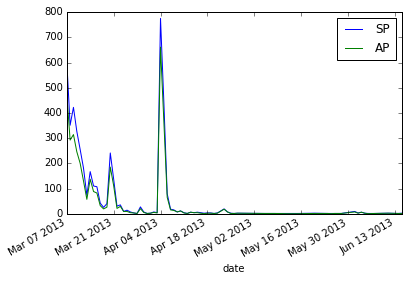

In [7]:
population['date'] = population.start_date.map(lambda x: pd.datetime.strptime(x, '%m/%d/%Y'))
population['SP'] = 1
enrollment = population.groupby('date')[['SP', 'AP']]

enrollment.sum().plot()

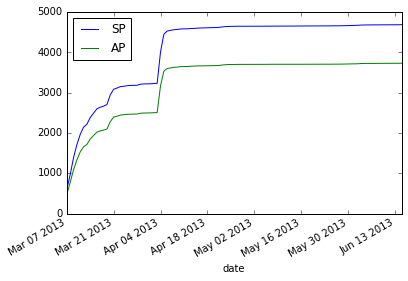

In [8]:
enrollment.sum().cumsum().plot()

This above plot shows that enrollment occurred in three waves beginning early March 2013, again near the end of March, and once more in the middle of April.

## Summarize demographics, covariates, exposures and outcomes

### Demographics

The tabulation below shows that our sample is largel white, non-Hispanic. Nearly two thirds of the participants have a college degree and rougly half make more than \$50,000 a year. The majority either are or have been married.

In [9]:
demographics = ['race', 'ethnicity', 'education', 'income', 'marital_status']
tables = [table(c) for c in demographics]
pd.concat(tables, keys=demographics)

n     %
race           White                                         3421  93.3
               Black or African-American                       44   1.2
               American Indian or Alaskan Native               22   0.6
               Asian                                           44   1.2
               Native Hawaiian or other Pacific Islander        8   0.2
               From multiple races                            127   3.5
ethnicity      Hispanic or Latino                             208   5.7
               Not Hispanic or Latino                        3435  94.3
education      Less than high school degree                    25   0.7
               High school degree or equivalent (e.g., GED)   178   4.8
               Some college but no degree                     697  18.7
               Associate degree                               370   9.9
               Bachelor degree                               1454  39.0
               Graduate degree                               1003  26.9
income         Less than \$10,000                              59   1.6
               \$10,000 - \$19,000                            101   2.8
               \$20,000 - \$29,000                            220   6.1
               \$30,000 - \$39,000                            314   8.8
               \$40,000 - \$49,000                            303   8.4
               \$50,000 - \$59,000                            325   9.1
               \$60,000 - \$69,000                            329   9.2
               \$70,000 - \$79,000                            363  10.1
               \$80,000 - \$89,000                            312   8.7
               \$90,000 - \$99,000                            293   8.2
               \$100,000 - \$149,000                          659  18.4
               \$150,000 or More                              308   8.6
marital_status Married                                       3436  92.2
               Widowed                                          6   0.2
               Divorced                                        36   1.0
               Separated                                       18   0.5
               Never married                                  229   6.1

### Covariates

The table below summarizes that prevalence of each category of the covariates listed in the next cell.

In [10]:
covariates = ['bmi_category',
 'alcohol',
 'smoke',
 'metformin',
 'BC_pills',
 'BC_age_group',
 'heart_surgery',
 'chest_injury',
 'breast_any_procedure',
 'transfusion',
 'hemorrhage',
 'diabetes_1',
 'diabetes_2',
 'diabetes_g',
 'POS',
 'thyroid',
 'depression',
 'stress',
 'breast_type',
 'menarche_group',
 'irregular_period',
 'breast_change',
 'conception',
 'natural_conception',
 'delivery_mode',
 'singleton',
 'baby_gestational_age',
 'baby_healthy',
 'baby_tongue_tie',
 'first_bf',
 'baby_in_bed',
 'pacifier',
 'swaddle',
 'baby_formula',
 'solid_food',
 'prior_bf']

pd.concat([table(c) for c in covariates], keys=covariates)

n  \
bmi_category         Underweight                                          111   
                     Normal weight                                       1659   
                     Overweight                                          1020   
                     Obese                                                899   
alcohol              Used alcohol weekly or daily while breastfeeding     792   
                     Used alcohol monthly, rarely or not at all whil...  2934   
smoke                Smoked cigarettes while breastfeeding                182   
                     Did not smoke cigarettes while breastfeeding        3527   
metformin            Yes                                                  242   
                     No                                                  3440   
BC_pills             Yes                                                 3198   
                     No                                                   519   
BC_age_group         (10, 12]                                              28   
                     (12, 13]                                              65   
                     (13, 14]                                             149   
                     (14, 15]                                             271   
                     (15, 16]                                             520   
                     (16, 17]                                             387   
                     (17, 18]                                             539   
                     (18, 19]                                             325   
                     (19, 20]                                             271   
                     (20, 50]                                             627   
heart_surgery        Heart surgery                                         23   
                     No heart surgery                                    3709   
chest_injury         Chest injury                                          23   
                     No chest injury                                     3709   
breast_any_procedure Any breast procedure                                 207   
                     No breast procedure                                 3525   
transfusion          Ever needed transfusion due to excessive blood ...   136   
                     Never needed transfusion due to excessive blood...  3506   
hemorrhage           Ever experienced hemorrhage or excessive bleedi...   573   
                     Never experienced hemorrhage or excessive bleed...  3104   
diabetes_1           Diagnosed with type I diabetes                        11   
                     Not diagnosed with type I diabetes                  3491   
diabetes_2           Diagnosed with type II diabetes                       15   
                     Not diagnosed with type II diabetes                 3487   
diabetes_g           Diagnosed with gestational diabetes                  290   
                     Not diagnosed with gestational diabetes             3212   
POS                  Diagnosed with polycystic ovarian syndrome           243   
                     Not diagnosed with polycystic ovarian syndrome      3259   
thyroid              Diagnosed with a thyroid disorder                    286   
                     Not diagnosed with a thyroid disorder               3216   
depression           Diagnosed with depression                            912   
                     Not diagnosed with depression                       2590   
stress               A major stressful event occurred while breastfe...   986   
                     No major stressful event occurred while breastf...  2734   
breast_type          Type 1                                              2149   
                     Type 2                                               700   
                     Type 3                                               109   
                     Type 

### Exposures (birth control while breast feeding)

The next table summarizes the prevalence of the exposures we're interest in (birth control while breast feeding). A number of birth control methods were extremely rare within the population, including copper IUD, combination birth control pill, patch, implant, birth control shot and vaginal ring.

Other birth control methods included abstinence, withdrawal, tubal ligation and vasectomy (however, I haven't coded these responses, so I can't give the frequencies).

In [11]:
exposures = survey.columns[survey.columns.str.startswith("bc_")].tolist()
pd.concat([table(c) for c in exposures], keys=exposures)

n  \
bc_NFP              Used Natural Family Planning after birth of child   1093   
                    Did not use Natural Family Planning after birth...  2611   
bc_barrier          Used Barrier after birth of child                   1546   
                    Did not use Barrier after birth of child            2163   
bc_copper_IUD       Used Copper IUD after birth of child                 156   
                    Did not use Copper IUD after birth of child         3555   
bc_hormonal_IUD     Used Hormonal IUD after birth of child               299   
                    Did not use Hormonal IUD after birth of child       3408   
bc_progestin_pill   Used Progestin-only birth control pill after bi...   533   
                    Did not use Progestin-only birth control pill a...  3180   
bc_combination_pill Used Combination birth control pill after birth...    42   
                    Did not use Combination birth control pill afte...  3657   
bc_patch            Used Patch after birth of child                        0   
                    Did not use Patch after birth of child              3710   
bc_implant          Used Implant after birth of child                     29   
                    Did not use Implant after birth of child            3677   
bc_shot             Used Shot after birth of child                        49   
                    Did not use Shot after birth of child               3648   
bc_ring             Used Vaginal ring after birth of child                20   
                    Did not use Vaginal ring after birth of child       3691   
bc_other            Used Other birth control after birth of child        555   
                    Did not use Other birth control after birth of ...  3160   

                                                                            %  
bc_NFP              Used Natural Family Planning after birth of child    29.5  
                    Did not use Natural Family Planning after birth...   70.5  
bc_barrier          Used Barrier after birth of child                    41.7  
                    Did not use Barrier after birth of child             58.3  
bc_copper_IUD       Used Copper IUD after birth of child                  4.2  
                    Did not use Copper IUD after birth of child          95.8  
bc_hormonal_IUD     Used Hormonal IUD after birth of child                8.1  
                    Did not use Hormonal IUD after birth of child        91.9  
bc_progestin_pill   Used Progestin-only birth control pill after bi...   14.4  
                    Did not use Progestin-only birth control pill a...   85.6  
bc_combination_pill Used Combination birth control pill after birth...    1.1  
                    Did not use Combination birth control pill afte...   98.9  
bc_patch            Used Patch after birth of child                       0.0  
                    Did not use Patch after birth of child              100.0  
bc_implant          Used Implant after birth of child                     0.8  
                    Did not use Implant after birth of child             99.2  
bc_shot             Used Shot after birth of child                        1.3  
                    Did not use Shot after birth of child                98.7  
bc_ring             Used Vaginal ring after birth of child                0.5  
                    Did not use Vaginal ring after birth of child        99.5  
bc_other            Used Other birth control after birth of child        14.9  
                    Did not use Other birth control after birth of ...   85.1

### Outcomes

The primary outcome is low milk supply determined from survey question 53.

In [12]:
outcomes = ['milk_supply', 'low_milk_supply']
pd.concat([table(c) for c in outcomes], keys=outcomes)

n     %
milk_supply     More than my baby needed                            1291  34.7
                Exactly what my baby needed                         1933  51.9
                Slightly less than my baby needed                    326   8.8
                A lot less than my baby needed                       171   4.6
low_milk_supply Milk supply slightly or a lot less than baby ne...   497  13.4
                Milk supply exactly what or more than baby needed   3224  86.6

Heuristically, there about about 500 positive outcomes, so the planned logistic model could support as many as 50 predictors. However, this does not take missing values into account, so we will want a model with considerably fewer variables.

## Outcome rates by demographics, covariates and exposures

The tables below tabulate the rate of the primary outcome by demographic, covariates and exposures. The table shows the number of participants who reported low milk supply, then the number who reported adequate supply, the rate of low milk supply as a percentage within the category, and a 95\% confidence interval for the percent. For some small categories, this confidence interval might include numbers below 0 or greater than 100 (don't rely on it in this cases!).

In [13]:
def tabulate_low_milk_supply(group):
    low_milk = survey.groupby([group, 'low_milk_supply']).size().unstack()
    low_milk.columns = low_milk.columns.astype('object')
    low_milk.index = low_milk.index.astype('object')
    
    low = low_milk['Milk supply slightly or a lot less than baby needed']
    n = low + low_milk['Milk supply exactly what or more than baby needed']
    
    rate = low / n
    rate_se = np.sqrt(rate * (1 - rate) / n)
    lcl = rate - 1.96*rate_se
    ucl = rate + 1.96*rate_se
    
    low_milk['rate'] = np.round(rate*1000)/10
    low_milk['lcl'] = np.round(lcl*1000)/10
    low_milk['ucl'] = np.round(ucl*1000)/10
    return low_milk


In [14]:
pd.concat([tabulate_low_milk_supply(d) for d in demographics], keys=demographics)

low_milk_supply                                              Milk supply slightly or a lot less than baby needed  \
race           White                                                                                     453.0     
               Black or African-American                                                                   9.0     
               American Indian or Alaskan Native                                                           2.0     
               Asian                                                                                       5.0     
               Native Hawaiian or other Pacific Islander                                                   1.0     
               From multiple races                                                                        16.0     
ethnicity      Hispanic or Latino                                                                         25.0     
               Not Hispanic or Latino                                                                    460.0     
education      Less than high school degree                                                                3.0     
               High school degree or equivalent (e.g., GED)                                               17.0     
               Some college but no degree                                                                 84.0     
               Associate degree                                                                           49.0     
               Bachelor degree                                                                           185.0     
               Graduate degree                                                                           158.0     
income         Less than \$10,000                                                                          9.0     
               \$10,000 - \$19,000                                                                         7.0     
               \$20,000 - \$29,000                                                                        33.0     
               \$30,000 - \$39,000                                                                        42.0     
               \$40,000 - \$49,000                                                                        23.0     
               \$50,000 - \$59,000                                                                        41.0     
               \$60,000 - \$69,000                                                                        40.0     
               \$70,000 - \$79,000                                                                        64.0     
               \$80,000 - \$89,000                                                                        35.0     
               \$90,000 - \$99,000                                                                        49.0     
               \$100,000 - \$149,000                                                                      96.0     
               \$150,000 or More                                                                          44.0     
marital_status Married                                                                                   454.0     
               Widowed                                                                                     NaN     
               Divorced                                                                                    5.0     
               Separated                                                                                   5.0     
               Never married                                                                              32.0     

low_milk_supply                                              Milk supply exactly what or more than baby needed  \
race           White                                                                                    2958.0   
               Black or African-American                   

In [15]:
pd.concat([tabulate_low_milk_supply(c) for c in covariates], keys=covariates)

low_milk_supply                                                          Milk supply slightly or a lot less than baby needed  \
bmi_category         Underweight                                                                                        13     
                     Normal weight                                                                                     164     
                     Overweight                                                                                        132     
                     Obese                                                                                             181     
alcohol              Used alcohol weekly or daily while breastfeeding                                                   91     
                     Used alcohol monthly, rarely or not at all whil...                                                406     
smoke                Smoked cigarettes while breastfeeding                                                              25     
                     Did not smoke cigarettes while breastfeeding                                                      467     
metformin            Yes                                                                                                38     
                     No                                                                                                450     
BC_pills             Yes                                                                                               433     
                     No                                                                                                 62     
BC_age_group         (10, 12]                                                                                            6     
                     (12, 13]                                                                                            5     
                     (13, 14]                                                                                           18     
                     (14, 15]                                                                                           30     
                     (15, 16]                                                                                           65     
                     (16, 17]                                                                                           57     
                     (17, 18]                                                                                           76     
                     (18, 19]                                                                                           51     
                     (19, 20]                                                                                           30     
                     (20, 50]                                                                                           94     
heart_surgery        Heart surgery                                                                                       3     
                     No heart surgery                                                                                  494     
chest_injury         Chest injury                                                                                        4     
                     No chest injury                                                                                   493     
breast_any_procedure Any breast procedure                                                                               49     
                     No breast procedure                                                                               448     
transfusion          Ever needed transfusion due to excessive blood ...                                                 15     
                     Never needed transfusion due to excessive blood...                                                473     
hemorrhage           Ever experi

In [16]:
pd.concat([tabulate_low_milk_supply(c) for c in exposures], keys=exposures)

low_milk_supply                                                         Milk supply slightly or a lot less than baby needed  \
bc_NFP              Used Natural Family Planning after birth of child                                                 116     
                    Did not use Natural Family Planning after birth...                                                376     
bc_barrier          Used Barrier after birth of child                                                                 225     
                    Did not use Barrier after birth of child                                                          270     
bc_copper_IUD       Used Copper IUD after birth of child                                                               23     
                    Did not use Copper IUD after birth of child                                                       473     
bc_hormonal_IUD     Used Hormonal IUD after birth of child                                                             40     
                    Did not use Hormonal IUD after birth of child                                                     457     
bc_progestin_pill   Used Progestin-only birth control pill after bi...                                                 79     
                    Did not use Progestin-only birth control pill a...                                                415     
bc_combination_pill Used Combination birth control pill after birth...                                                 14     
                    Did not use Combination birth control pill afte...                                                478     
bc_patch            Did not use Patch after birth of child                                                            494     
bc_implant          Used Implant after birth of child                                                                   3     
                    Did not use Implant after birth of child                                                          489     
bc_shot             Used Shot after birth of child                                                                      5     
                    Did not use Shot after birth of child                                                             486     
bc_ring             Used Vaginal ring after birth of child                                                              4     
                    Did not use Vaginal ring after birth of child                                                     490     
bc_other            Used Other birth control after birth of child                                                      77     
                    Did not use Other birth control after birth of ...                                                418     

low_milk_supply                                                         Milk supply exactly what or more than baby needed  \
bc_NFP              Used Natural Family Planning after birth of child                                                 973   
                    Did not use Natural Family Planning after birth...                                               2229   
bc_barrier          Used Barrier after birth of child                                                                1315   
                    Did not use Barrier after birth of child                                                         1889   
bc_copper_IUD       Used Copper IUD after birth of child                                                              130   
                    Did not use Copper IUD after birth of child                                                      3074   
bc_hormonal_IUD     Used Hormonal IUD after birth of child                                                            259   
                    Did not use Hormonal IUD after birth of child                                                    2941   
bc_progestin_pill   Used Progestin-only birth control pill after bi...          

## Univariate odds ratios of outcome by covariates and exposures

This table complements the above table by showing the so-called relative risk of low milk supply as it depends on the demographics, covariates and exposures. Each of the summaries below has one fewer category than the tables above: the missing category serves as the reference for the group.

For example, the white participants are missing from the summary of race in the next table. Their relative risk is 1.00, and the odds ratios that follow compare the risk of low risk supply among each race group to the white. Black or African American participants had 68% elevated risk of low milk supply compared to white participants, but the p-value shows the risk elevation could may just be noise.

In [17]:
def uOR(column):
    fml = 'low_milk_supply ~ {}'.format(column)
    model = smf.glm(formula=fml, data=survey, family=sm.families.Binomial()).fit()
    
    ci = model.conf_int()
    
    # Convert parameter estimates to odds ratios
    parameters = pd.DataFrame({'Odds ratio': np.round(np.exp(model.params)*100)/100})
    parameters['95% confidence interval (lower)'] = np.round(np.exp(ci[0])*100)/100
    parameters['95% confidence interval (upper)'] = np.round(np.exp(ci[1])*100)/100
    parameters['p-value'] = np.round(model.pvalues*1000)/1000
    
    parameters.index = parameters.index.astype('object')
    
    return parameters[1:]

In [18]:
pd.concat([uOR(d) for d in demographics], keys=demographics)

Odds ratio  \
race           race[T.Black or African-American]                         1.68   
               race[T.American Indian or Alaskan Native]                 0.69   
               race[T.Asian]                                             0.84   
               race[T.Native Hawaiian or other Pacific Islander]         0.93   
               race[T.From multiple races]                               0.94   
ethnicity      ethnicity[T.Not Hispanic or Latino]                       1.14   
education      education[T.High school degree or equivalent (e...        0.75   
               education[T.Some college but no degree]                   0.96   
               education[T.Associate degree]                             1.07   
               education[T.Bachelor degree]                              1.02   
               education[T.Graduate degree]                              1.31   
income         income[T.\$10,000 - \$19,000]                             0.41   
               income[T.\$20,000 - \$29,000]                             0.99   
               income[T.\$30,000 - \$39,000]                             0.86   
               income[T.\$40,000 - \$49,000]                             0.46   
               income[T.\$50,000 - \$59,000]                             0.80   
               income[T.\$60,000 - \$69,000]                             0.77   
               income[T.\$70,000 - \$79,000]                             1.19   
               income[T.\$80,000 - \$89,000]                             0.70   
               income[T.\$90,000 - \$99,000]                             1.12   
               income[T.\$100,000 - \$149,000]                           0.95   
               income[T.\$150,000 or More]                               0.93   
marital_status marital_status[T.Widowed]                                 0.00   
               marital_status[T.Divorced]                                1.06   
               marital_status[T.Separated]                               2.52   
               marital_status[T.Never married]                           1.07   

                                                                   95% confidence interval (lower)  \
race           race[T.Black or African-American]                                              0.80   
               race[T.American Indian or Alaskan Native]                                      0.16   
               race[T.Asian]                                                                  0.33   
               race[T.Native Hawaiian or other Pacific Islander]                              0.11   
               race[T.From multiple races]                                                    0.55   
ethnicity      ethnicity[T.Not Hispanic or Latino]                                            0.74   
education      education[T.High school degree or equivalent (e...                             0.20   
               education[T.Some college but no degree]                                        0.28   
               education[T.Associate degree]                                                  0.31   
               education[T.Bachelor degree]                                                   0.30   
               education[T.Graduate degree]                                                   0.39   
income         income[T.\$10,000 - \$19,000]                                                  0.15   
               income[T.\$20,000 - \$29,000]                                                  0.44   
               income[T.\$30,000 - \$39,000]                                                  0.39   
               income[T.\$40,000 - \$49,000]                                                  0.20   
               income[T.\$50,000 - \$59,000]                                                  0.37   
               income[T.\$60,000 - \$69,000]                                                  0.35   
               income[T.\$70,000 - \$79,000

In [19]:
covariates = ['age_mother'] + covariates
pd.concat([uOR(c) for c in covariates], keys=covariates)

Odds ratio  \
age_mother           age_mother                                                1.03   
bmi_category         bmi_category[T.Normal weight]                             0.83   
                     bmi_category[T.Overweight]                                1.13   
                     bmi_category[T.Obese]                                     1.91   
alcohol              alcohol[T.Used alcohol monthly, rarely or not a...        1.23   
smoke                smoke[T.Did not smoke cigarettes while breastfe...        0.95   
metformin            metformin[T.No]                                           0.81   
BC_pills             BC_pills[T.No]                                            0.87   
BC_age_group         BC_age_group[T.(12, 13]]                                  0.31   
                     BC_age_group[T.(13, 14]]                                  0.50   
                     BC_age_group[T.(14, 15]]                                  0.46   
                     BC_age_group[T.(15, 16]]                                  0.53   
                     BC_age_group[T.(16, 17]]                                  0.64   
                     BC_age_group[T.(17, 18]]                                  0.60   
                     BC_age_group[T.(18, 19]]                                  0.69   
                     BC_age_group[T.(19, 20]]                                  0.46   
                     BC_age_group[T.(20, 50]]                                  0.65   
heart_surgery        heart_surgery[T.No heart surgery]                         1.03   
chest_injury         chest_injury[T.No chest injury]                           0.73   
breast_any_procedure breast_any_procedure[T.No breast procedure]               0.47   
transfusion          transfusion[T.Never needed transfusion due to e...        1.24   
hemorrhage           hemorrhage[T.Never experienced hemorrhage or ex...        1.06   
diabetes_1           diabetes_1[T.Not diagnosed with type I diabetes]          0.68   
diabetes_2           diabetes_2[T.Not diagnosed with type II diabetes]         0.61   
diabetes_g           diabetes_g[T.Not diagnosed with gestational dia...        0.97   
POS                  POS[T.Not diagnosed with polycystic ovarian syn...        0.96   
thyroid              thyroid[T.Not diagnosed with a thyroid disorder]          0.82   
depression           depression[T.Not diagnosed with depression]               0.81   
stress               stress[T.No major stressful event occurred whil...        1.17   
breast_type          breast_type[T.Type 2]                                     2.38   
                     breast_type[T.Type 3]                                     2.73   
                     breast_type[T.Type 4]                                     1.81   
                     breast_type[T.Other]                                      1.56   
menarche_group       menarche_group[T.(10, 11]]                                1.55   
                     menarche_group[T.(11, 12]]                                1.43   
                     menarche_group[T.(12, 13]]                                1.37   
                     menarche_group[T.(13, 14]]                                1.47   
                     menarche_group[T.(14, 15]]                                0.63   
                     menarche_group[T.(15, 16]]                                1.05   
                     menarche_group[T.(16, 21]]                                1.01   
irregular_period     irregular_period[T.Regular period]                        0.89   
breast_change        breast_change[T.Less than 1 cup size]                     0.78   
                     breast_change[T.About 1 cup size]                         0.37   
                     breast_change[T.More than 1 cup size]                     0.26   
conception           conception[T.Naturally, but it took over a year]          1.32   
                     conception[T.Using Clomid]                        

In [20]:
pd.concat([uOR(e) for e in exposures], keys=exposures)

,,Odds ratio,95% confidence interval (lower),95% confidence interval (upper),p-value
bc_NFP,bc_NFP[T.Did not use Natural Family Planning after birth of child],1.41,1.13,1.77,0.002
bc_barrier,bc_barrier[T.Did not use Barrier after birth of child],0.84,0.69,1.01,0.064
bc_copper_IUD,bc_copper_IUD[T.Did not use Copper IUD after birth of child],0.87,0.55,1.37,0.547
bc_hormonal_IUD,bc_hormonal_IUD[T.Did not use Hormonal IUD after birth of child],1.01,0.71,1.42,0.972
bc_progestin_pill,bc_progestin_pill[T.Did not use Progestin-only birth control pill after birth of child],0.86,0.67,1.12,0.269
bc_combination_pill,bc_combination_pill[T.Did not use Combination birth control pill after birth of child],0.30,0.16,0.58,0.000
bc_patch,bc_patch[T.Did not use Patch after birth of child],0.42,0.40,0.45,0.000
bc_implant,bc_implant[T.Did not use Implant after birth of child],1.33,0.40,4.42,0.638
bc_shot,bc_shot[T.Did not use Shot after birth of child],1.36,0.54,3.44,0.521
bc_ring,bc_ring[T.Did not use Vaginal ring after birth of child],0.61,0.20,1.85,0.385


## Adjusted odds ratios

The approach is to use forward step-wise selection on the subset of the "most significant" variables above. First, since `statsmodels` does not have this dodgy model selection technique already, we define a forward selector class to do the deed.

We summarize the steps in the selection and then the coefficients in the selected model.

TODO Use Hosmer-Lemeshow to look at goodness of fit.

In [21]:
class ForwardSelector:
    def __init__(self, formula, predictors):
        self.predictors = set(predictors)
        self.fml = formula
        
        self.history = []
        
    def _model(self, formula):
        return smf.glm(formula=formula, data=survey, family=sm.families.Binomial()).fit()
    
    def step(self):
        fml = self.fml + ' + {}'
        
        aic = []
        for p in self.predictors:
            model = self._model(fml.format(p))
            aic.append((model.aic, model.df_model, model.llf, p))
            
        aic.sort()
        
        best = aic[0]
        
        self.history.append(best)
        self.fml = self.fml + ' + ' + best[-1]
        self.predictors.remove(best[-1])
        
    def select(self):
        while len(self.predictors) > 0:
            try:
                self.step()
            except:
                return
            
    def summary(self):
        st = pd.DataFrame(fs.history, columns=['aic', 'df', 'LL', 'variable'])
        st['LLd'] = 2*st.LL.diff()
        st['dfd'] = st.df.diff()
        st['p-value'] = stats.chi2.sf(st.LLd, st.dfd)
        st['p-value'] = np.round(st['p-value'] * 1000) / 1000
        return st

In [22]:
# Demographics were not that important as univariate predictors
demographics = []


# Get rid of rare birth control methods
exposures = ['bc_NFP',
 'bc_barrier',
 'bc_hormonal_IUD',
 'bc_progestin_pill',
 'bc_other']

# The subset of "most significant" predictors from the univariate analysis above
covariates =['age_mother',
  'bmi_category',
  'alcohol',
  'BC_age',
  'breast_any_procedure',
  'depression',
  'breast_type',
  'menarche',
  'irregular_period',
  'breast_change',
  'natural_conception',
  'delivery_mode',
  'baby_gestational_age',
  'baby_healthy',
  'baby_tongue_tie',
  'first_bf',
  'baby_in_bed',
  'pacifier',
  'swaddle',
  'baby_formula',
  'solid_food']

In [23]:
formula = 'low_milk_supply ~ ' + ' + '.join(demographics + exposures)

In [24]:
fs = ForwardSelector(formula, covariates)
fs.select()
result = fs.summary()

In [25]:
result

,aic,df,LL,variable,LLd,dfd,p-value
0,2210.204326,6,-1098.102163,baby_formula,NaN,NaN,NaN
1,1716.717097,7,-850.358548,solid_food,495.487229,1.0,0.000
2,1498.947203,8,-740.473601,BC_age,219.769894,1.0,0.000
3,1330.911244,9,-655.455622,baby_healthy,170.035959,1.0,0.000
4,1246.594671,10,-612.297335,depression,86.316573,1.0,0.000
5,1167.226698,13,-569.613349,first_bf,85.367973,3.0,0.000
6,1120.659925,16,-543.329962,breast_change,52.566773,3.0,0.000
7,1090.721406,18,-526.360703,baby_tongue_tie,33.938519,2.0,0.000
8,1071.146343,21,-513.573171,bmi_category,25.575064,3.0,0.000
9,1056.697903,22,-505.348952,breast_any_procedure,16.448439,1.0,0.000


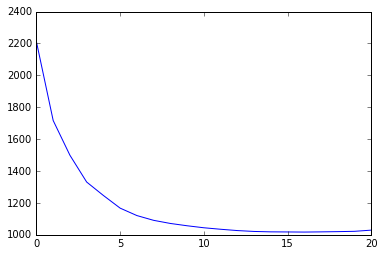

In [26]:
result.aic.plot()

In [27]:
selected_formula = formula + ' + ' + ' + '.join(result[result['p-value'] < 0.05].variable)
model = smf.glm(formula=selected_formula, data=survey, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                               Generalized Linear Model Regression Results                                                                                
==========================================================================================================================================================================================================
Dep. Variable:     ['low_milk_supply[Milk supply slightly or a lot less than baby needed]', 'low_milk_supply[Milk supply exactly what or more than baby needed]']   No. Observations:                 1967
Model:                                                                                                                                                        GLM   Df Residuals:                     1937
Model Family:                                                                                                                                            Binomial   Df Model:                           29
Link Function:                                                                                                                                              logit   Scale:                             1.0
Method:                                                                                                                                                      IRLS   Log-Likelihood:                -628.47
Date:                                                                                                                                            Sat, 20 Aug 2016   Deviance:                       1256.9
Time:                                                                                                                                                    12:12:40   Pearson chi2:                 1.88e+03
No. Iterations:                                                                                                                                                 8                                         
===========================================================================================================================================================
                                                                                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  -1.1770      1.636     -0.720      0.472        -4.383     2.029
bc_NFP[T.Did not use Natural Family Planning after birth of child]                          0.2703      0.188      1.439      0.150        -0.098     0.638
bc_barrier[T.Did not use Barrier after birth of child]                                     -0.0779      0.151     -0.516      0.606        -0.373     0.218
bc_hormonal_IUD[T.Did not use Hormonal IUD after birth of child]                           -0.1495      0.239     -0.625      0.532        -0.619     0.319
bc_progestin_pill[T.Did not use Progestin-only birth control pill after birth of child]    -0.0127      0.199     -0.064      0.949        -0.402     0.376
bc_other[T.Did not use Other birth control after birth of child]                            0.0987      0.219      0.451      0.652        -0.330     0.528
solid_food[T.Started baby on solid food at or after six months]                            -0.9615      0.155     -6.217      0.000        -1.265    -0.658
baby_healthy[T.Baby has been diagnosed with chronic health problems]                        0.5591      0.287      1.950      0.051        -0.003     1.121
depression[T.Not diagnosed with depression]                                                -0.0718      0.171     -0.421      0.674        -0.406     0.262
first_bf[T.Within 4 hours]                        

TODO Hosmer-Lemeshow goes here

Preliminarily, hormonal IUD (Mirena) does not have a clear association with low milk supply. Based on the $p$-values, the most important factors associated with low milk supply are whether or not baby recieved formula, change in breast size during pregnancy, whether or not baby started solid food within the first 6 months of birth, whether or not mother had had any breast procedures done, tongue tie, baby starting the night in mother's bed, and pacifier usage. Age of mother was not significant after adjusting for the other factors in the model.

Of course, there are some caveats with this model. For instance, mother's with low milk supply may start formula and solid food early, so we might consider removing these terms (and perhaps others that could be caused by low milk supply).